# CNN in image classification

In [1]:
'''
Environment: 
Ubuntu 18LTS 1080Ti

Package version: 
Python3.6, keras2.1.6, backend is tensorflow-gpu 1.8.0
numpy 1.14.2, matplotlib 2.1.2 
'''
import keras
import os
import numpy as np
import matplotlib.image as mpimg
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D,Dropout
from keras.layers import Concatenate, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import matplotlib.pyplot as plt
import pydot
%matplotlib inline

/Users/chenquan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Hyperparameters
epochs = 200
lr = 0.0005
dropout_rate_1 = 0.3
dropout_rate_2 = 0.2
dropout_rate_3 = 0.1
batch_size = 256
num_classes = 62
adm = optimizers.Adam(lr=lr,decay=0.000001)

In [3]:
# Path using Ubuntu
x_train_path = '/home/quanchen/Shared/train-set/'
y_train_path = '/home/quanchen/Shared/train.txt'

x_vali_path = '/home/quanchen/Shared/vali-set/'
y_vali_path = '/home/quanchen/Shared/vali.txt'

## Load data to numpy array

In [4]:
# x_train, x_vali --> (nb_samples,128,128,1)
# x_vali, y_vali --> (nb_samples,)
y_data_train = np.loadtxt(y_train_path,dtype=bytes)[:,1].astype(float)
y_vali = np.loadtxt(y_vali_path,dtype=bytes)[:,1].astype(float)

# get the (n,128*128) (n,16384)array
# method one
# x_train=[]
# for file in sorted(os.listdir(x_train_path)):
#     x_train.append(mpimg.imread(x_train_path + file).reshape(128,128,1))
# x_train = np.array(x_train)

# x_vali=[]
# for file in sorted(os.listdir(x_vali_path)):
#     x_vali.append(mpimg.imread(x_vali_path + file).reshape(128,128,1))
# x_vali = np.array(x_vali)

# method two
x_data_train=[]
for file in sorted(os.listdir(x_train_path)):
    x_data_train.append(np.expand_dims(mpimg.imread(x_train_path + file),-1))
x_data_train = np.array(x_data_train)

x_vali=[]
for file in sorted(os.listdir(x_vali_path)):
    x_vali.append(np.expand_dims(mpimg.imread(x_vali_path + file),-1))
x_vali = np.array(x_vali)

# change label to one hot
y_data_train = keras.utils.to_categorical(y_data_train, num_classes)
y_vali = keras.utils.to_categorical(y_vali, num_classes)

# shullfer train data
indecies = np.random.permutation(len(y_data_train))
x_train = x_data_train[indecies]
y_train = y_data_train[indecies]

img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

del x_data_train
del y_data_train

print('img_height: ',img_height)
print('img_width: ', img_width)
print('channel: ', channel)
print('x_train: ',x_train.shape)
print('y_train: ', y_train.shape)
print('x_vali: ', x_vali.shape)
print('y_vali: ', y_vali.shape)

img_height:  128
img_width:  128
channel:  1
x_train:  (37882, 128, 128, 1)
y_train:  (37882, 62)
x_vali:  (6262, 128, 128, 1)
y_vali:  (6262, 62)


## Cheack whether data is right after shullfering

7
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


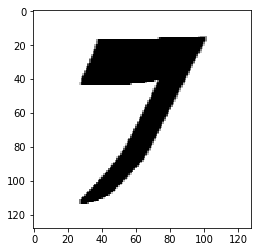

In [5]:
checkindex = 100
print(np.argmax(y_train[checkindex]))
print(y_train[checkindex])
plt.imshow(x_train[checkindex].reshape(128,128),cmap ='gray')

## Define ImageDataGenerator
This funtion will be use to rotate train image, shift their location 
accoding to width and height and zoom them in or out. 

In [6]:
# data generator with one data augmentation
datagen = ImageDataGenerator(
    #featurewise_std_normalization=True,
    rotation_range=12,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range = 0.05)

datagen.fit(x_train,augment=True,rounds=1)

## Model detail
Input --> Droupout --> Conv --> Maxpooling -->
Droupout --> Conv -->Maxpooling --> Droupout -->
Conv --> Maxpolling --> Dense --> Dense --> Dense

In [7]:
# Model detail
input = Input(shape=(img_height, img_width, channel,))
input_dp = Dropout(0.1)(input)
conv_1 = Conv2D(32, (5,5), use_bias=True ,padding='same',activation = 'relu')(input_dp)
maxpool_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
maxpool_1_dp = Dropout(0.15)(maxpool_1)
conv_2 = Conv2D(64, (5,5), use_bias=True ,padding='same',activation = 'relu')(maxpool_1_dp)
maxpool_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
maxpool_2_dp = Dropout(0.15)(maxpool_2)
conv_3 = Conv2D(64, (5,5), use_bias=True ,padding='same',activation = 'relu')(maxpool_2_dp)
maxpool_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
# dp = Dropout(0.25)(maxpool_2)

flat_1 = Flatten()(maxpool_3)
dense_1 = Dense(1024,activation='relu',use_bias=True)(flat_1)
dense_2 = Dense(1024,activation='relu',use_bias=True)(dense_1)
output = Dense(62,activation='softmax',use_bias=True)(dense_2)

In [8]:
model = Model(inputs=[input], outputs=[output])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
__________

## Compile our model

In [9]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=adm,
              metrics=['accuracy'])

In [10]:
# using generator
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train)/batch_size,
                    epochs=epochs,validation_data=(x_vali,y_vali))

Epoch 1/200
148/147 [==============================] - 29s 197ms/step - loss: 1.6716 - acc: 0.5614 - val_loss: 0.6641 - val_acc: 0.7986
Epoch 2/200
148/147 [==============================] - 28s 187ms/step - loss: 0.6208 - acc: 0.7992 - val_loss: 0.4876 - val_acc: 0.8379
Epoch 3/200
148/147 [==============================] - 28s 189ms/step - loss: 0.4915 - acc: 0.8295 - val_loss: 0.3967 - val_acc: 0.8593
Epoch 4/200
148/147 [==============================] - 28s 188ms/step - loss: 0.4214 - acc: 0.8490 - val_loss: 0.3886 - val_acc: 0.8508
Epoch 5/200
148/147 [==============================] - 28s 188ms/step - loss: 0.3729 - acc: 0.8573 - val_loss: 0.3456 - val_acc: 0.8746
Epoch 6/200
148/147 [==============================] - 28s 189ms/step - loss: 0.3416 - acc: 0.8679 - val_loss: 0.3214 - val_acc: 0.8772
Epoch 7/200
148/147 [==============================] - 28s 188ms/step - loss: 0.3197 - acc: 0.8736 - val_loss: 0.3109 - val_acc: 0.8825
Epoch 8/200
148/147 [===========================

Epoch 119/200
148/147 [==============================] - 28s 187ms/step - loss: 0.0870 - acc: 0.9612 - val_loss: 0.2790 - val_acc: 0.9166
Epoch 120/200
148/147 [==============================] - 28s 188ms/step - loss: 0.0906 - acc: 0.9600 - val_loss: 0.2672 - val_acc: 0.9189
Epoch 121/200
148/147 [==============================] - 28s 187ms/step - loss: 0.0874 - acc: 0.9608 - val_loss: 0.2774 - val_acc: 0.9138
Epoch 122/200
148/147 [==============================] - 28s 187ms/step - loss: 0.0905 - acc: 0.9602 - val_loss: 0.2612 - val_acc: 0.9171
Epoch 123/200
148/147 [==============================] - 28s 189ms/step - loss: 0.0873 - acc: 0.9617 - val_loss: 0.2894 - val_acc: 0.9160
Epoch 124/200
148/147 [==============================] - 28s 188ms/step - loss: 0.0889 - acc: 0.9594 - val_loss: 0.2765 - val_acc: 0.9179
Epoch 125/200
148/147 [==============================] - 28s 188ms/step - loss: 0.0863 - acc: 0.9613 - val_loss: 0.3309 - val_acc: 0.9035
Epoch 126/200
148/147 [===========

## Show the loss trend

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


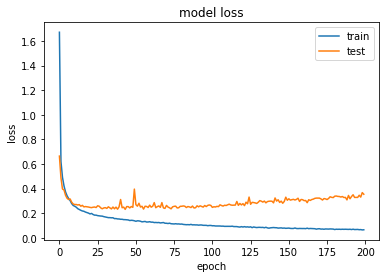

In [11]:
print(history.history.keys())

fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

## Show the accuracy trend

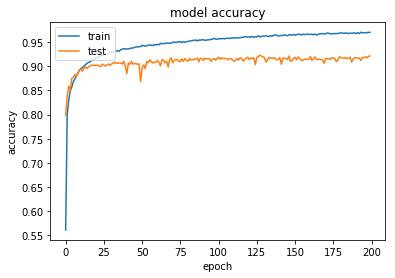

In [12]:
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

## Save model to local file

In [16]:
model.save('my_model-5E-5-WD-DP-E200-9213.h5') 

## Load model and show their structure

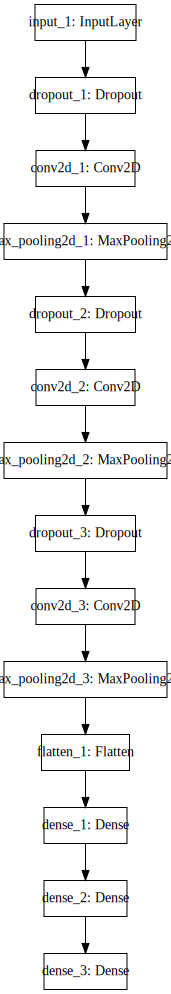

In [3]:
model = load_model('my_model-5E-5-WD-DP-E200-9213.h5')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))